# CIFAR-10

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset

from torchvision import models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.neighbors import KernelDensity

from tqdm import tqdm

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from PIL import Image

from joblib import Parallel, delayed

from utlis import renormalize_image, vectorize_tensor, reconstruct_tensor
import ld

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Setup

### General

In [2]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    cp.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

load = False

set_random_seed(42)
k = 3
bandwidth = 0.05
bandwidth_AE = 0.05
eps = np.asarray(1.0e-5)
plot_num = 20
paper_plot_num = 1

### Dataset

In [ ]:
class NumpyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy.array): Array of shape (N, H, W, C).
            labels (numpy.array): Labels array of shape (N,).
            transform (callable, optional): Transformations to apply to each sample.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        # Convert (H, W, C) -> (C, H, W) for PyTorch
        img = torch.tensor(img).permute(2, 0, 1).float() / 255.0

        # Apply transformation if provided
        if self.transform:
            img = self.transform(img)

        return img, label

In [3]:
D = 32*32*3
S = (2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2)
train_size_per_digit = 5000
test_size_per_digit = 1000
new_sample_size_per_digit = 1000

# Print dataset statistics
print(f"Train size: {train_size_per_digit * 10}")
print(f"Test size: {test_size_per_digit * 10}")
print(f"New sample size: {new_sample_size_per_digit * 10}")
print(f"Number of classes: 10")
print(f"Number of features: {D}")

In [4]:
train_dataset = datasets.CIFAR10(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),]))

save_dir = './data/CIFAR10_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    # Save images by class
    for class_label in range(10):
        class_dir = os.path.join(save_dir, str(class_label))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        basis = np.where(np.array(train_dataset.targets) == class_label)[0]
        for i, idx in enumerate(basis):
            img, _ = train_dataset[idx]
            img = transforms.ToPILImage()(img)
            img.save(os.path.join(class_dir, f'{i}.png'))

Files already downloaded and verified
Files already downloaded and verified


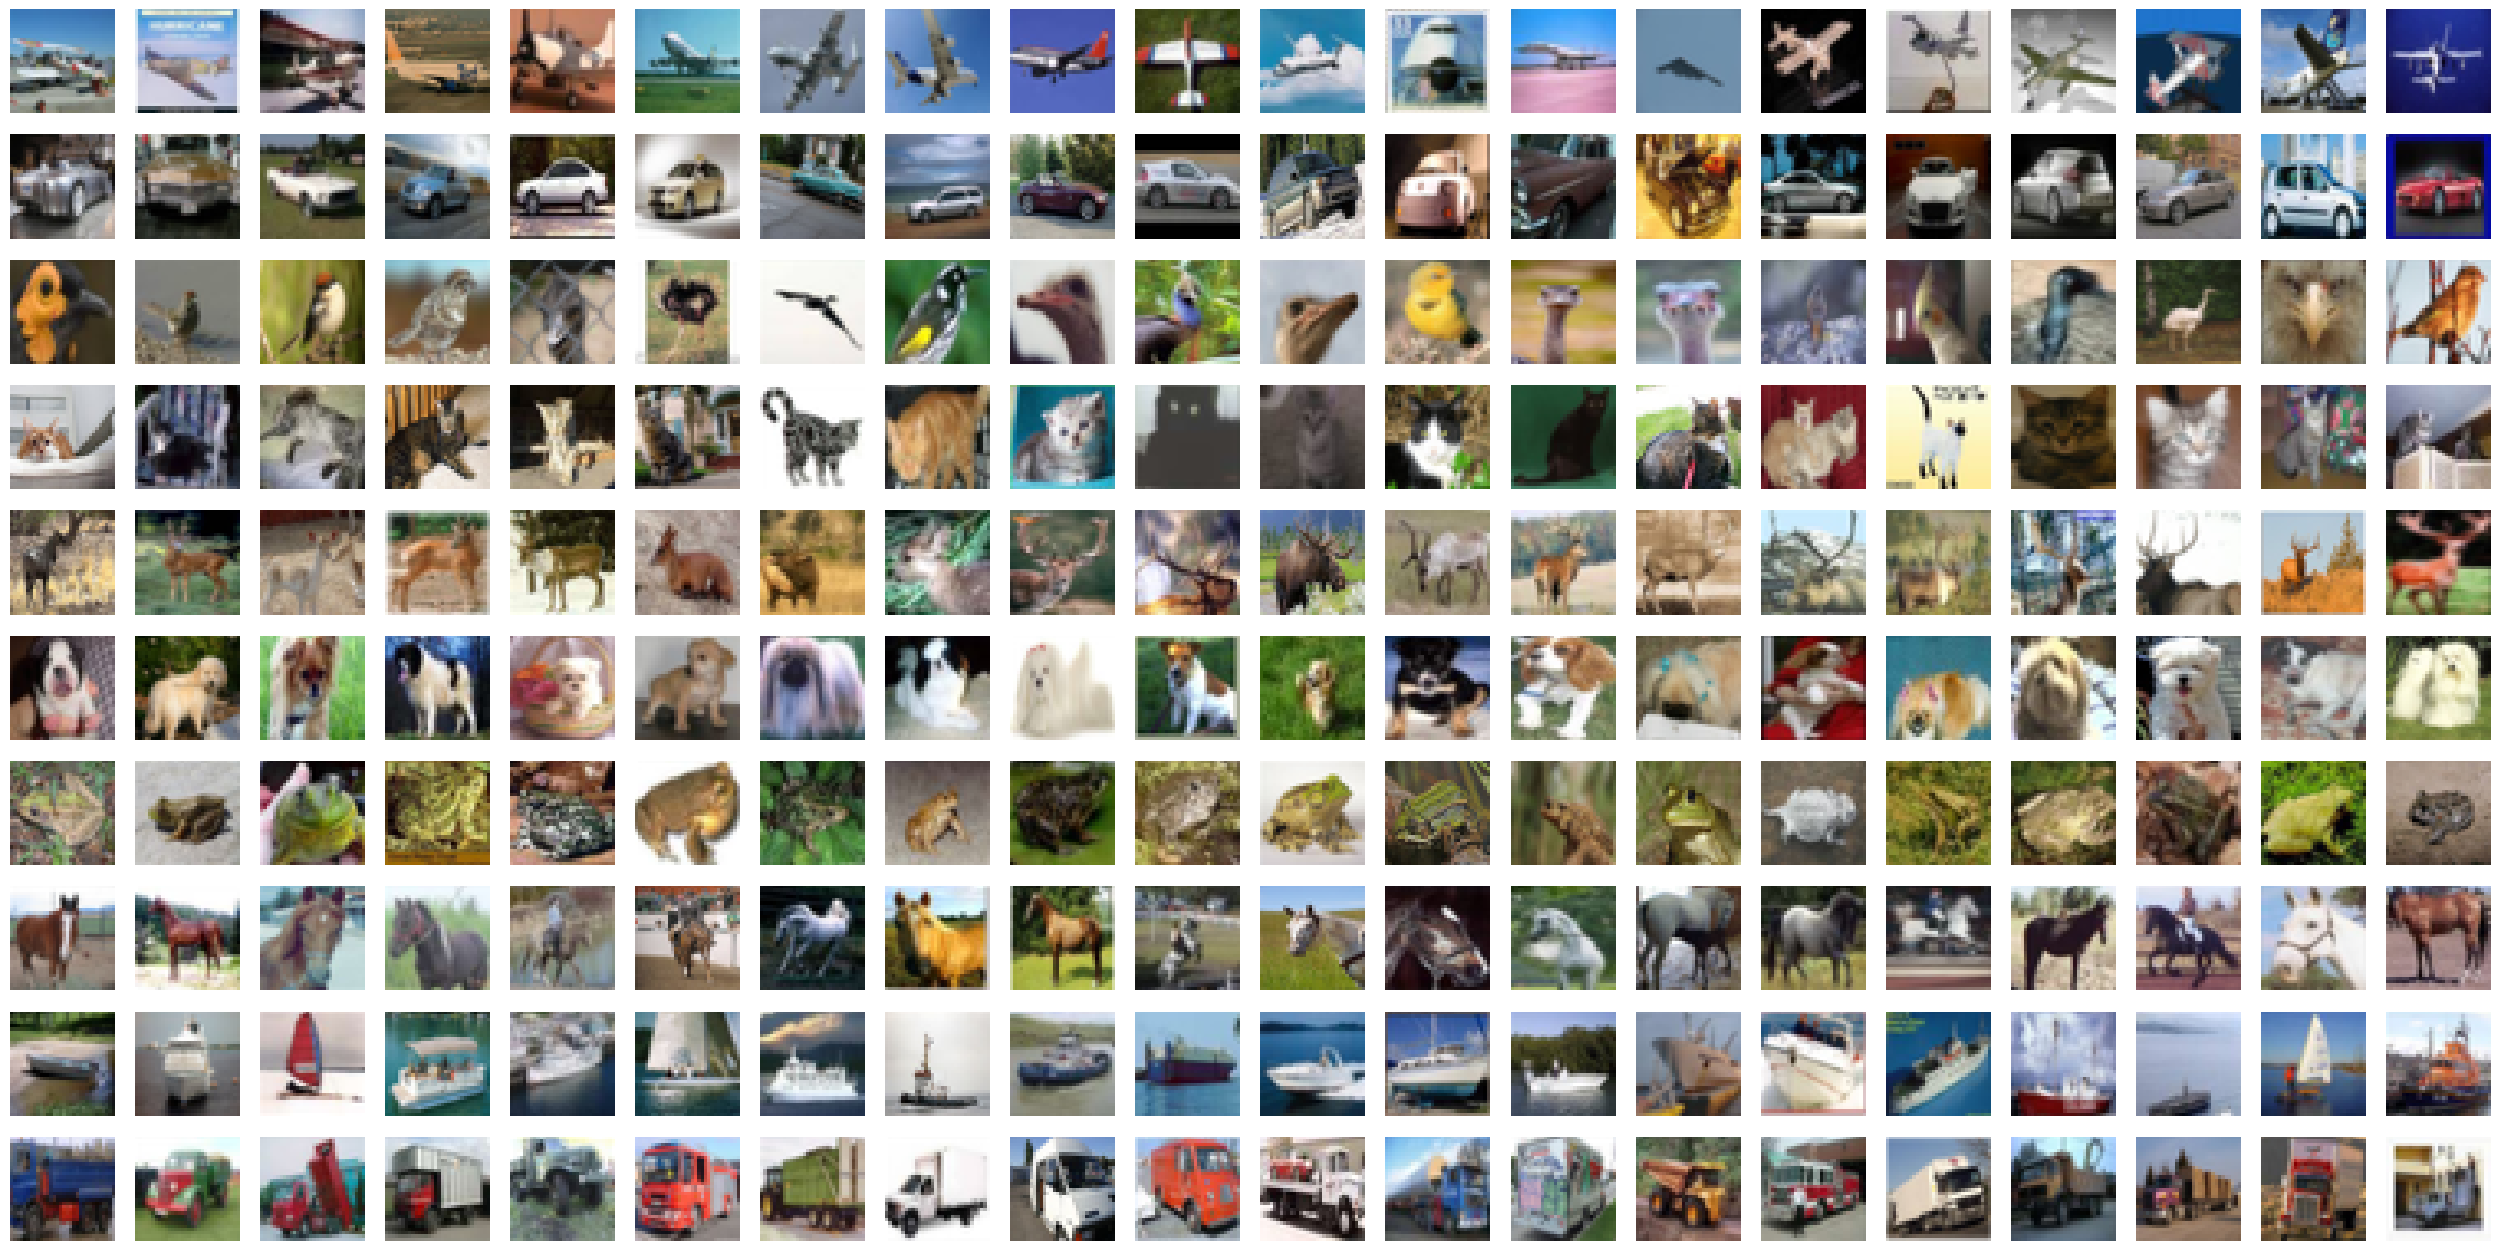

In [5]:
# Function to load images from a directory
def load_images_from_folder(folder, max_images=20):
    images = []
    for filename in os.listdir(folder)[:max_images]:
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

P_class = []
original_data = []

for class_ in range(10):
    class_folder = os.path.join(save_dir, str(class_))
    images = load_images_from_folder(class_folder, max_images=train_size_per_digit)

    P = []
    for img in images:
        img = img.resize((32, 32))
        original_data.append(np.asarray(img))
        array_obj = np.asarray(img).reshape(S)
        P.append(array_obj)

    P_class.append(np.array(P))

# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for class_ in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, class_ * plot_num + i + 1)
        plt.imshow(P_class[class_][i].reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

## Direct Fitting

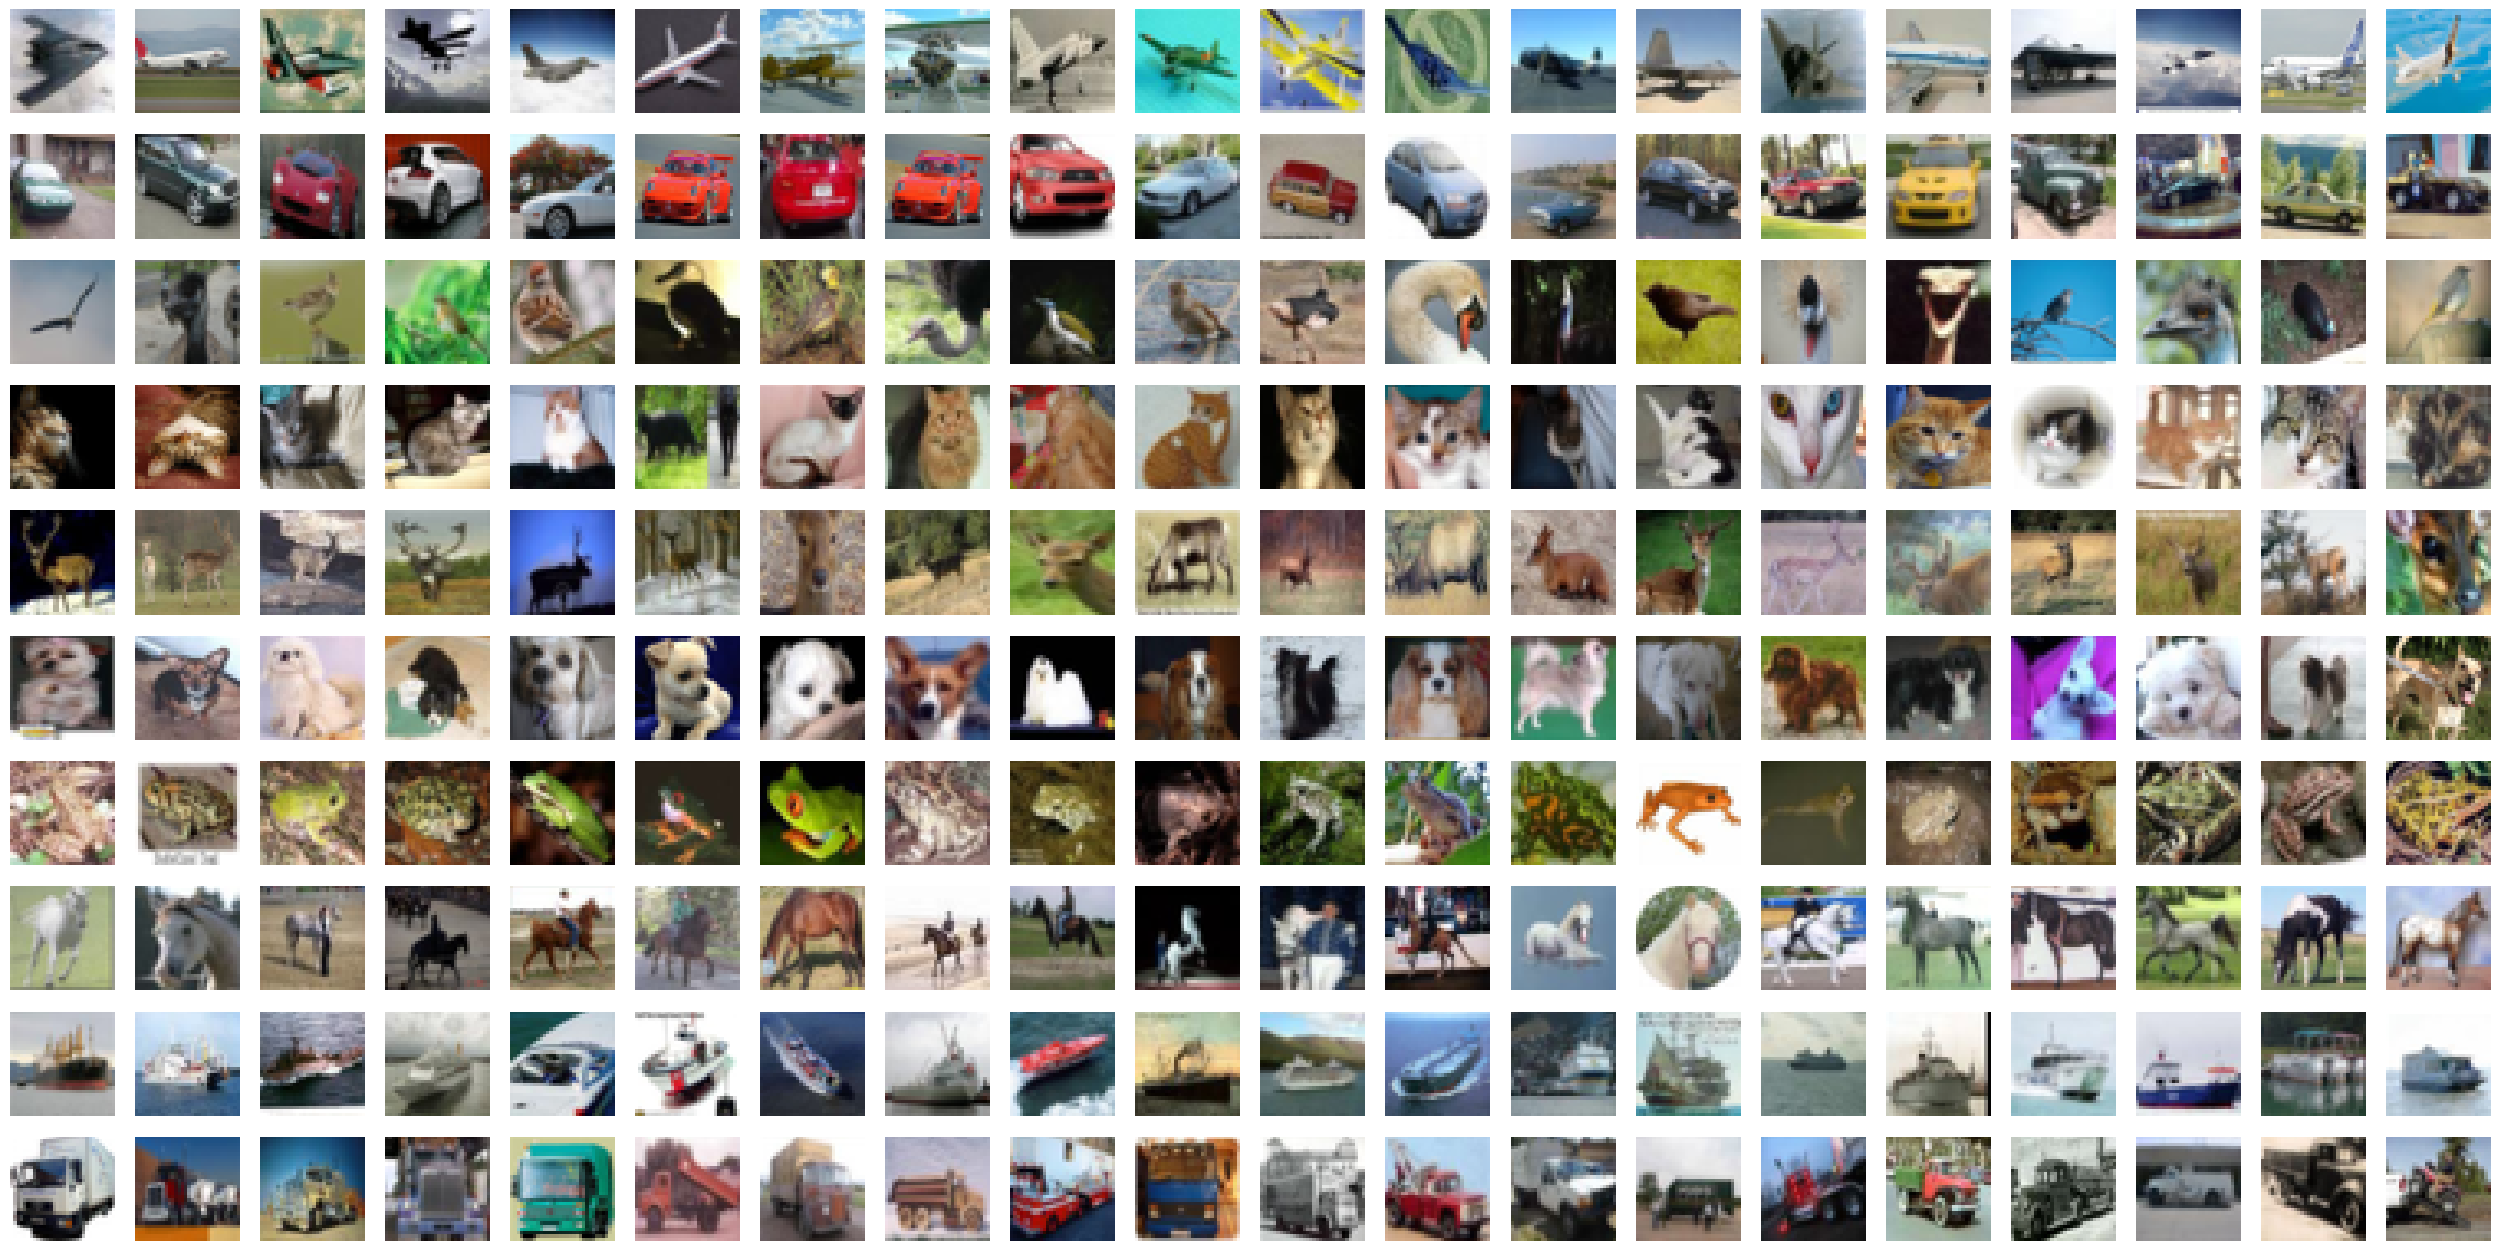

In [6]:
B_LD = ld.default_B(S, len(S), cp.get_array_module(P[0])) # Full Basis (direct fitting essentially)

sampled_P_class = []

for class_ in range(10):
    reduced_P = vectorize_tensor(P_class[class_], B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=30).fit(reduced_P)

    # Sample new data from the KDE
    sampled_reduced_P = kde.sample(n_samples=new_sample_size_per_digit)

    sampled_P = reconstruct_tensor(sampled_reduced_P, (new_sample_size_per_digit, *S), B_LD)
    sampled_P_class.append(sampled_P)

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for class_ in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_P_class[class_][i].reshape((32, 32, 3)) - p.reshape((32, 32, 3))) for p in P_class[class_]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, class_ * plot_num + i + 1)
        plt.imshow(P_class[class_][idx].reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

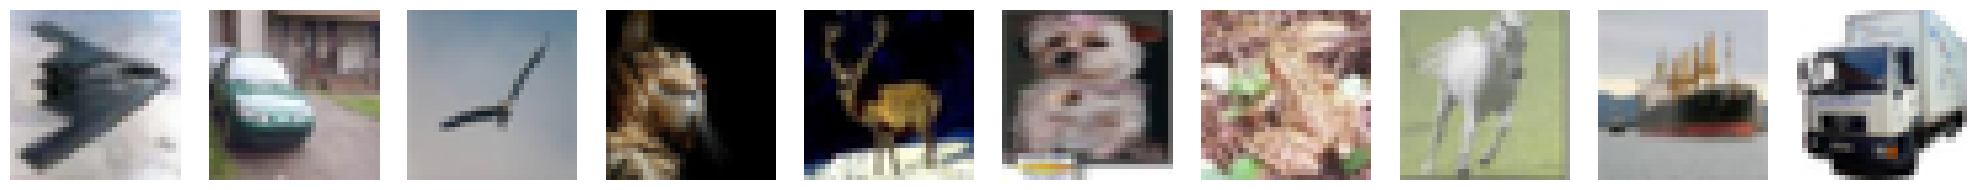

In [7]:
# plt.figure(figsize=(20, 2))
# for class_ in range(10):
#     for i in range(paper_plot_num):
#         plt.subplot(paper_plot_num, 10, class_ * paper_plot_num + i + 1)
#         plt.imshow(sampled_P_class[class_][i].reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255)
#         plt.axis('off')  # Hide axes

# plt.tight_layout()

# plt.savefig('../Figures/CIFAR/else/direct_fitting.pdf', format='pdf')

# plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for class_ in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_P_class[class_][i].reshape((32, 32, 3)) - p.reshape((32, 32, 3))) for p in P_class[class_]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, class_ * paper_plot_num + i + 1)
        plt.imshow(P_class[class_][idx].reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/CIFAR/else/direct_fitting_compare.pdf', format='pdf')

plt.show()

## Pseudo-Non-Linear Data Augmentation

### Legendre Decomposition (Many-Body Approximation)

In [8]:
B_LD = ld.default_B(S, 5, cp.get_array_module(P[0]))
print(f"Dimension of Base Sub-Manifold: {B_LD.shape[0]}")

# Store all intermediate results to disk
if load:
    # Load all intermediate results from disk
    results = np.load('results_LD.npz')
    scaleX_class = results['scaleX_class']
    Q_class = results['Q_class']
    theta_class = results['theta_class']
    X_recons_class = results['X_recons_class']
else:
    def LD_helper(i, class_):
        _, _, scaleX, Q, theta = ld.LD(P_class[class_][i], B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
        return (scaleX, Q, theta)

    results = Parallel(n_jobs=30)(delayed(LD_helper)(i, class_) for i in range(train_size_per_digit) for class_ in range(10))

    scaleX_class = []
    Q_class = []
    theta_class = []
    X_recons_class = []

    for class_ in range(10):
        scaleX_list = []
        Q_list = []
        theta_list = []
        X_recons_list = []
        for i in range(train_size_per_digit):
            result = results[i*10 + class_]

            scaleX_list.append(result[0])
            Q_list.append(result[1])
            theta_list.append(result[2])
            X_recons = (result[1] * result[0]).astype(np.int32)
            X_recons_list.append(X_recons)

        scaleX_class.append(np.array(scaleX_list))
        Q_class.append(np.array(Q_list))
        theta_class.append(np.array(theta_list))
        X_recons_class.append(np.array(X_recons_list))

    np.savez('results_LD.npz', scaleX_class=scaleX_class, Q_class=Q_class, theta_class=theta_class, X_recons_class=X_recons_class)

(1410, 11)


OutOfMemoryError: Out of memory allocating 87,538,688 bytes (allocated so far: 167,353,344 bytes).

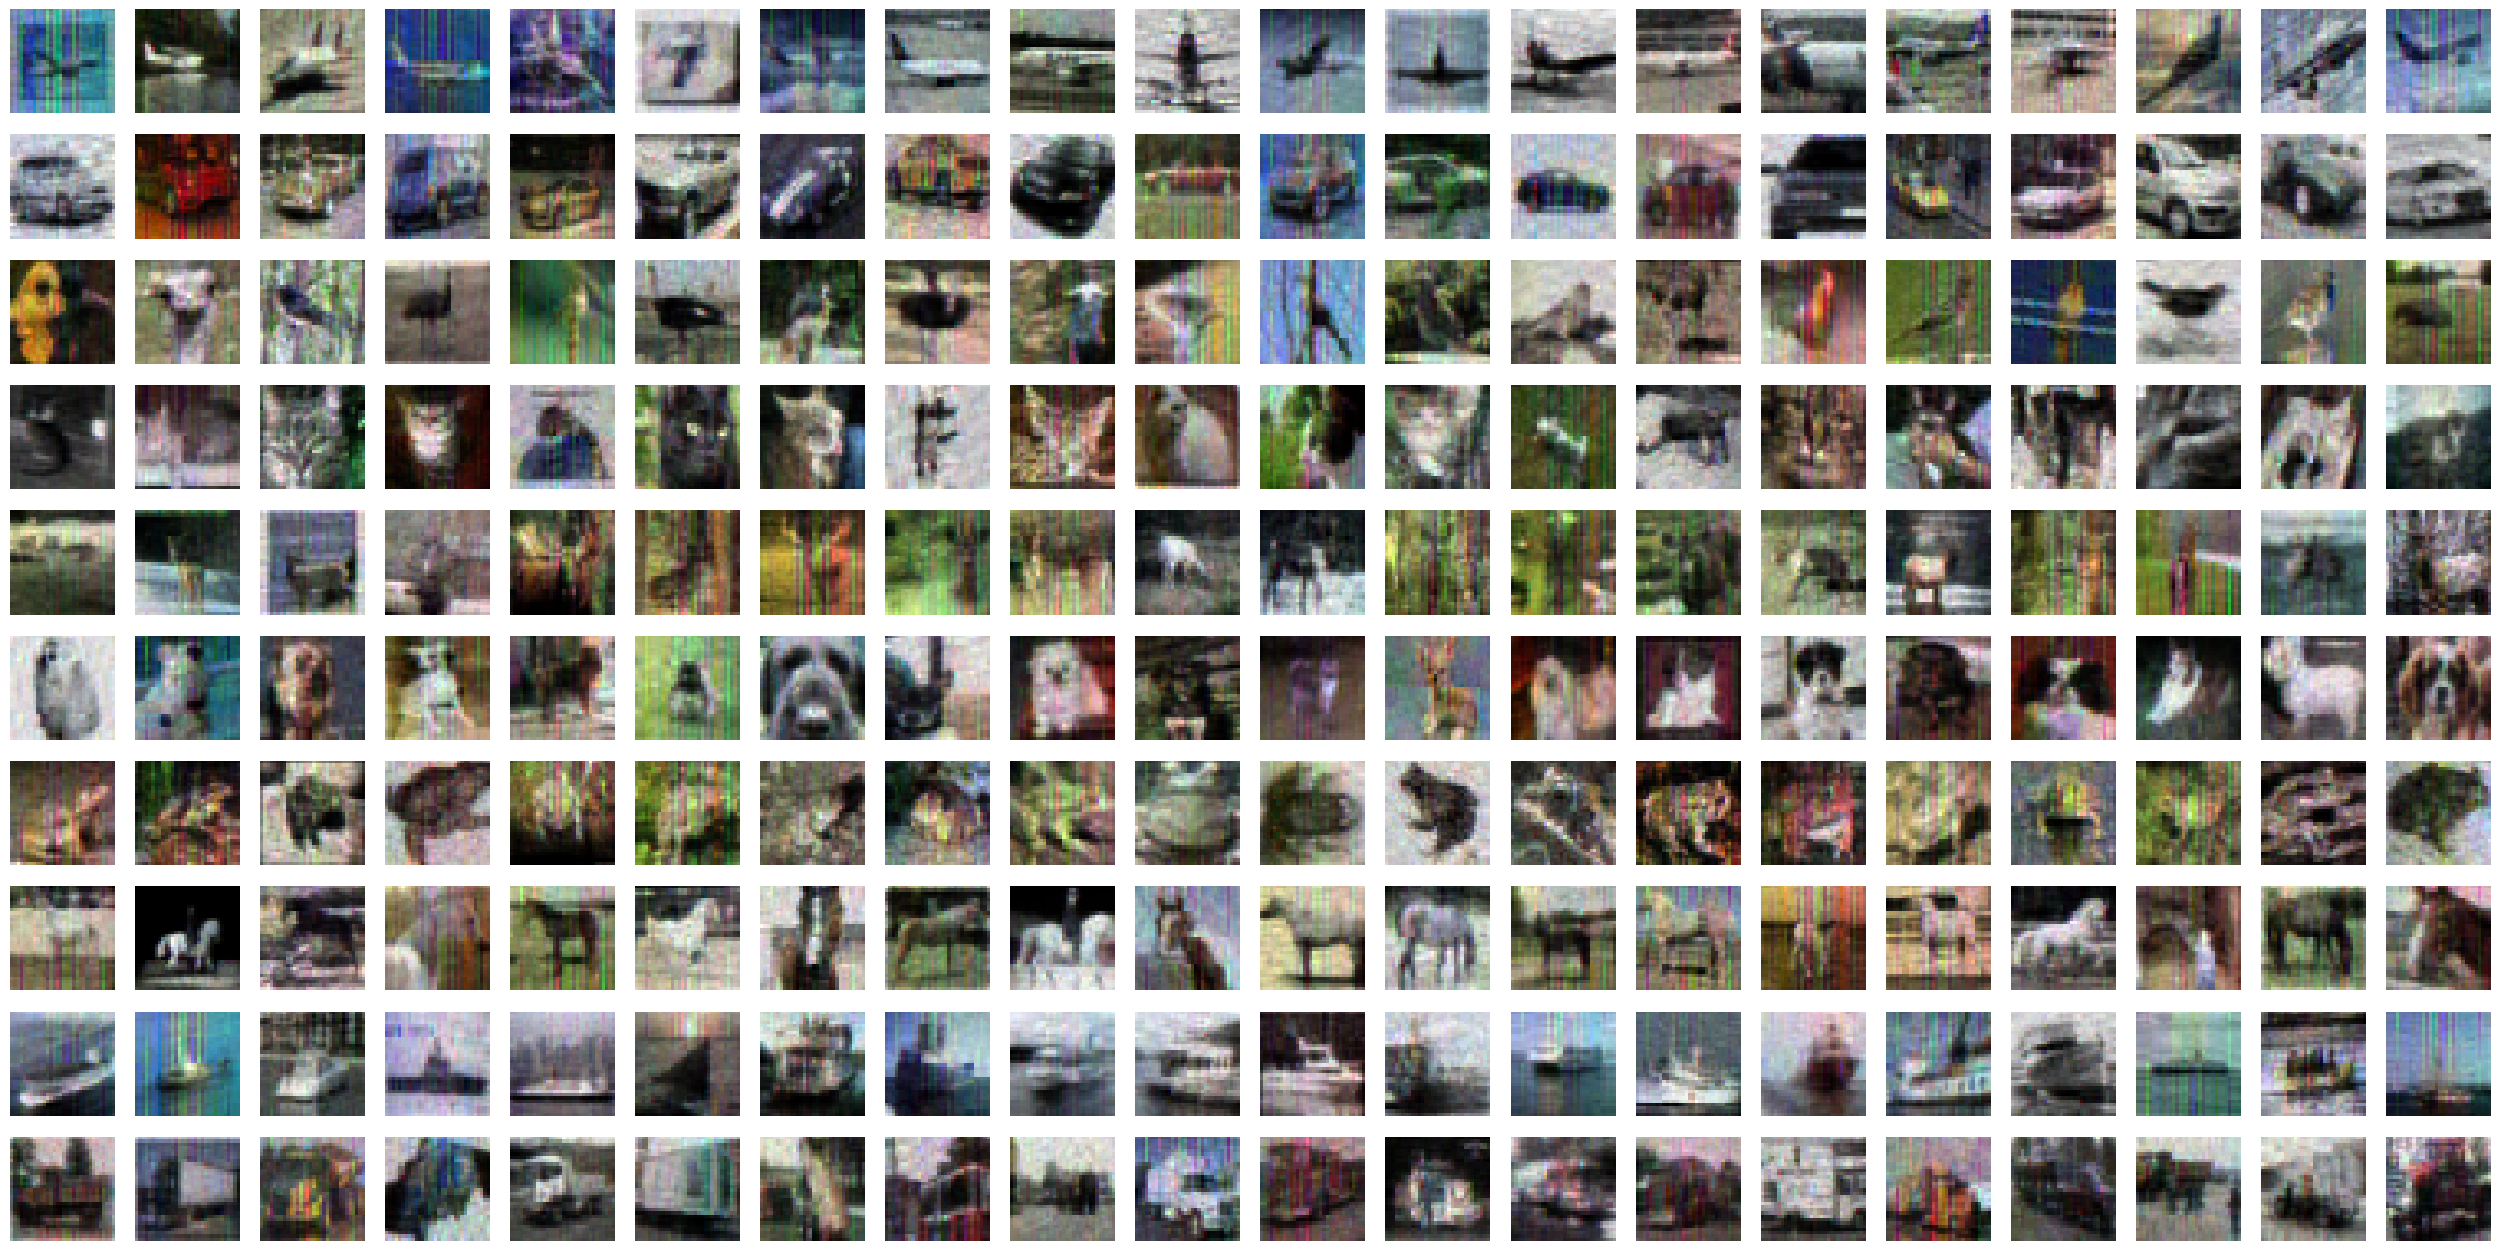

In [ ]:
# Load and display images horizontally for each class
plt.figure(figsize=(32, 16))
for class_ in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, class_ * plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_class[class_][i]).reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# plt.figure(figsize=(32, 16))
# for class_ in range(10):
#     for i in range(plot_num):
#         plt.subplot(10, plot_num, class_ * plot_num + i + 1)
#         plt.imshow(theta_class[class_][i].reshape((32, 32, 3)), cmap='coolwarm', vmin=-15, vmax=15)
#         plt.axis('off')  # Hide axes

# plt.show()

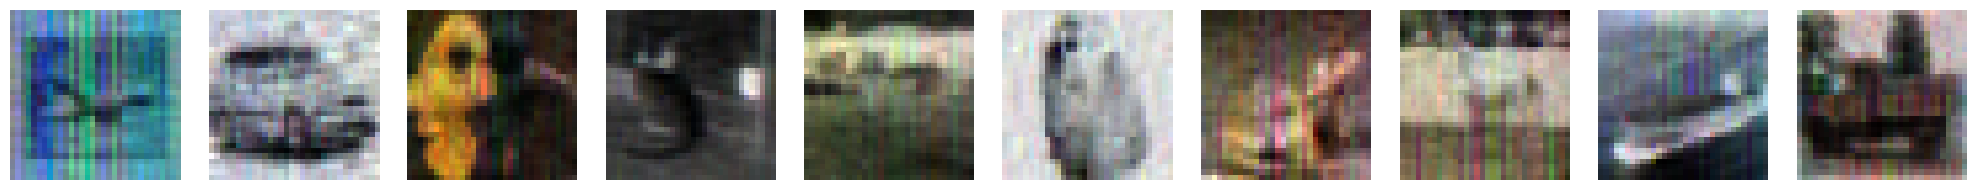

In [10]:
plt.figure(figsize=(20, 2))
for class_ in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, class_ * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(X_recons_class[class_][i]).reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/CIFAR/default/LD.pdf', format='pdf')

plt.show()

# # Find the nearest distance between every new sample among the training set in terms of norm.
# plt.figure(figsize=(20, 2))
# for class_ in range(10):
#     for i in range(paper_plot_num):
#         plt.subplot(paper_plot_num, 10, class_ * paper_plot_num + i + 1)
#         plt.imshow(theta_class[class_][i].reshape((32, 32, 3)), cmap='coolwarm', vmin=-15, vmax=15)
#         plt.axis('off')  # Hide axes

# plt.tight_layout()

# plt.savefig('../Figures/CIFAR/default/LD_parameter.pdf', format='pdf')

# plt.show()

#### Fitting on Projected Points

In [11]:
sampled_theta_class = []

for class_ in range(10):
    reduced_theta = vectorize_tensor(theta_class[class_], B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(reduced_theta)
    # Sample new data from the KDE
    sampled_reduced_theta = kde.sample(n_samples=new_sample_size_per_digit)

    sampled_theta = reconstruct_tensor(sampled_reduced_theta, (new_sample_size_per_digit, *S), B_LD)
    sampled_theta_class.append(sampled_theta)

#### Construct Local Data Sub-Manifold

In [12]:
# Construct the constrained coordinates
# B_BP = ld.block_B([14, 14], [15, 15])
B_BP = ld.default_B(S, 4, cp.get_array_module(P[0]))
print(f"Dimension of Local Data Sub-Manifold: {D - B_BP.shape[0]}")

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_class = []

for class_ in range(10):
    eta_hat_list = []
    for i in range(P_class[class_].shape[0]):
        xp = cp.get_array_module(P_class[class_][i])
        P = (P_class[class_][i] + eps) / scaleX_class[class_][i]
        eta_hat = ld.get_eta(P, len(S), xp)
        eta_hat_list.append(eta_hat)

    eta_hat_class.append(cp.asarray(eta_hat_list))

(738, 11)


#### Backward Projection

In [15]:
if load:
    # Load all intermediate results from disk
    results_BP = np.load('results_BP.npz')
    sampled_P_BP_class = results_BP['sampled_P_BP_class']
    sampled_theta_BP_class = results_BP['sampled_theta_BP_class']
    sampled_X_BP_class = results_BP['sampled_X_BP_class']
else:
    # Use a custom temporary directory
    import tempfile
    temp_dir = tempfile.mkdtemp(dir='/data/pbb/tmp')


    def BP_helper(i, class_):
        N = ld.kNN(sampled_theta_class[class_][i], theta_class[class_], k=k)
        avg_scale = np.mean(scaleX_class[class_][N])
        avg_eta_hat = np.mean(eta_hat_class[class_][N], axis=0)
        _, _, P, theta = ld.BP(sampled_theta_class[class_][i], [(P_class[class_][j] + eps) / scaleX_class[class_][j] for j in N], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=1e-1)
        X_recons_ = (P).astype(np.int32).reshape(-1)
        return (P, theta, X_recons_)

    results = Parallel(n_jobs=10, temp_folder=temp_dir)(delayed(BP_helper)(i, class_) for i in range(new_sample_size_per_digit) for class_ in range(10))

    sampled_P_BP_class = []
    sampled_theta_BP_class = []
    sampled_X_BP_class = []

    for class_ in range(10):
        sampled_P_BP = []
        sampled_theta_BP = []
        sampled_X_BP = []
        for i in range(new_sample_size_per_digit):
            result = results[i*10 + class_]

            sampled_P_BP.append(result[0])
            sampled_theta_BP.append(result[1])
            sampled_X_BP.append(result[2])

        sampled_P_BP_class.append(np.array(sampled_P_BP))
        sampled_theta_BP_class.append(np.array(sampled_theta_BP))
        sampled_X_BP_class.append(np.array(sampled_X_BP))

    np.savez('results_BP.npz', sampled_P_BP_class=sampled_P_BP_class, sampled_theta_BP_class=sampled_theta_BP_class, sampled_X_BP_class=sampled_X_BP_class)

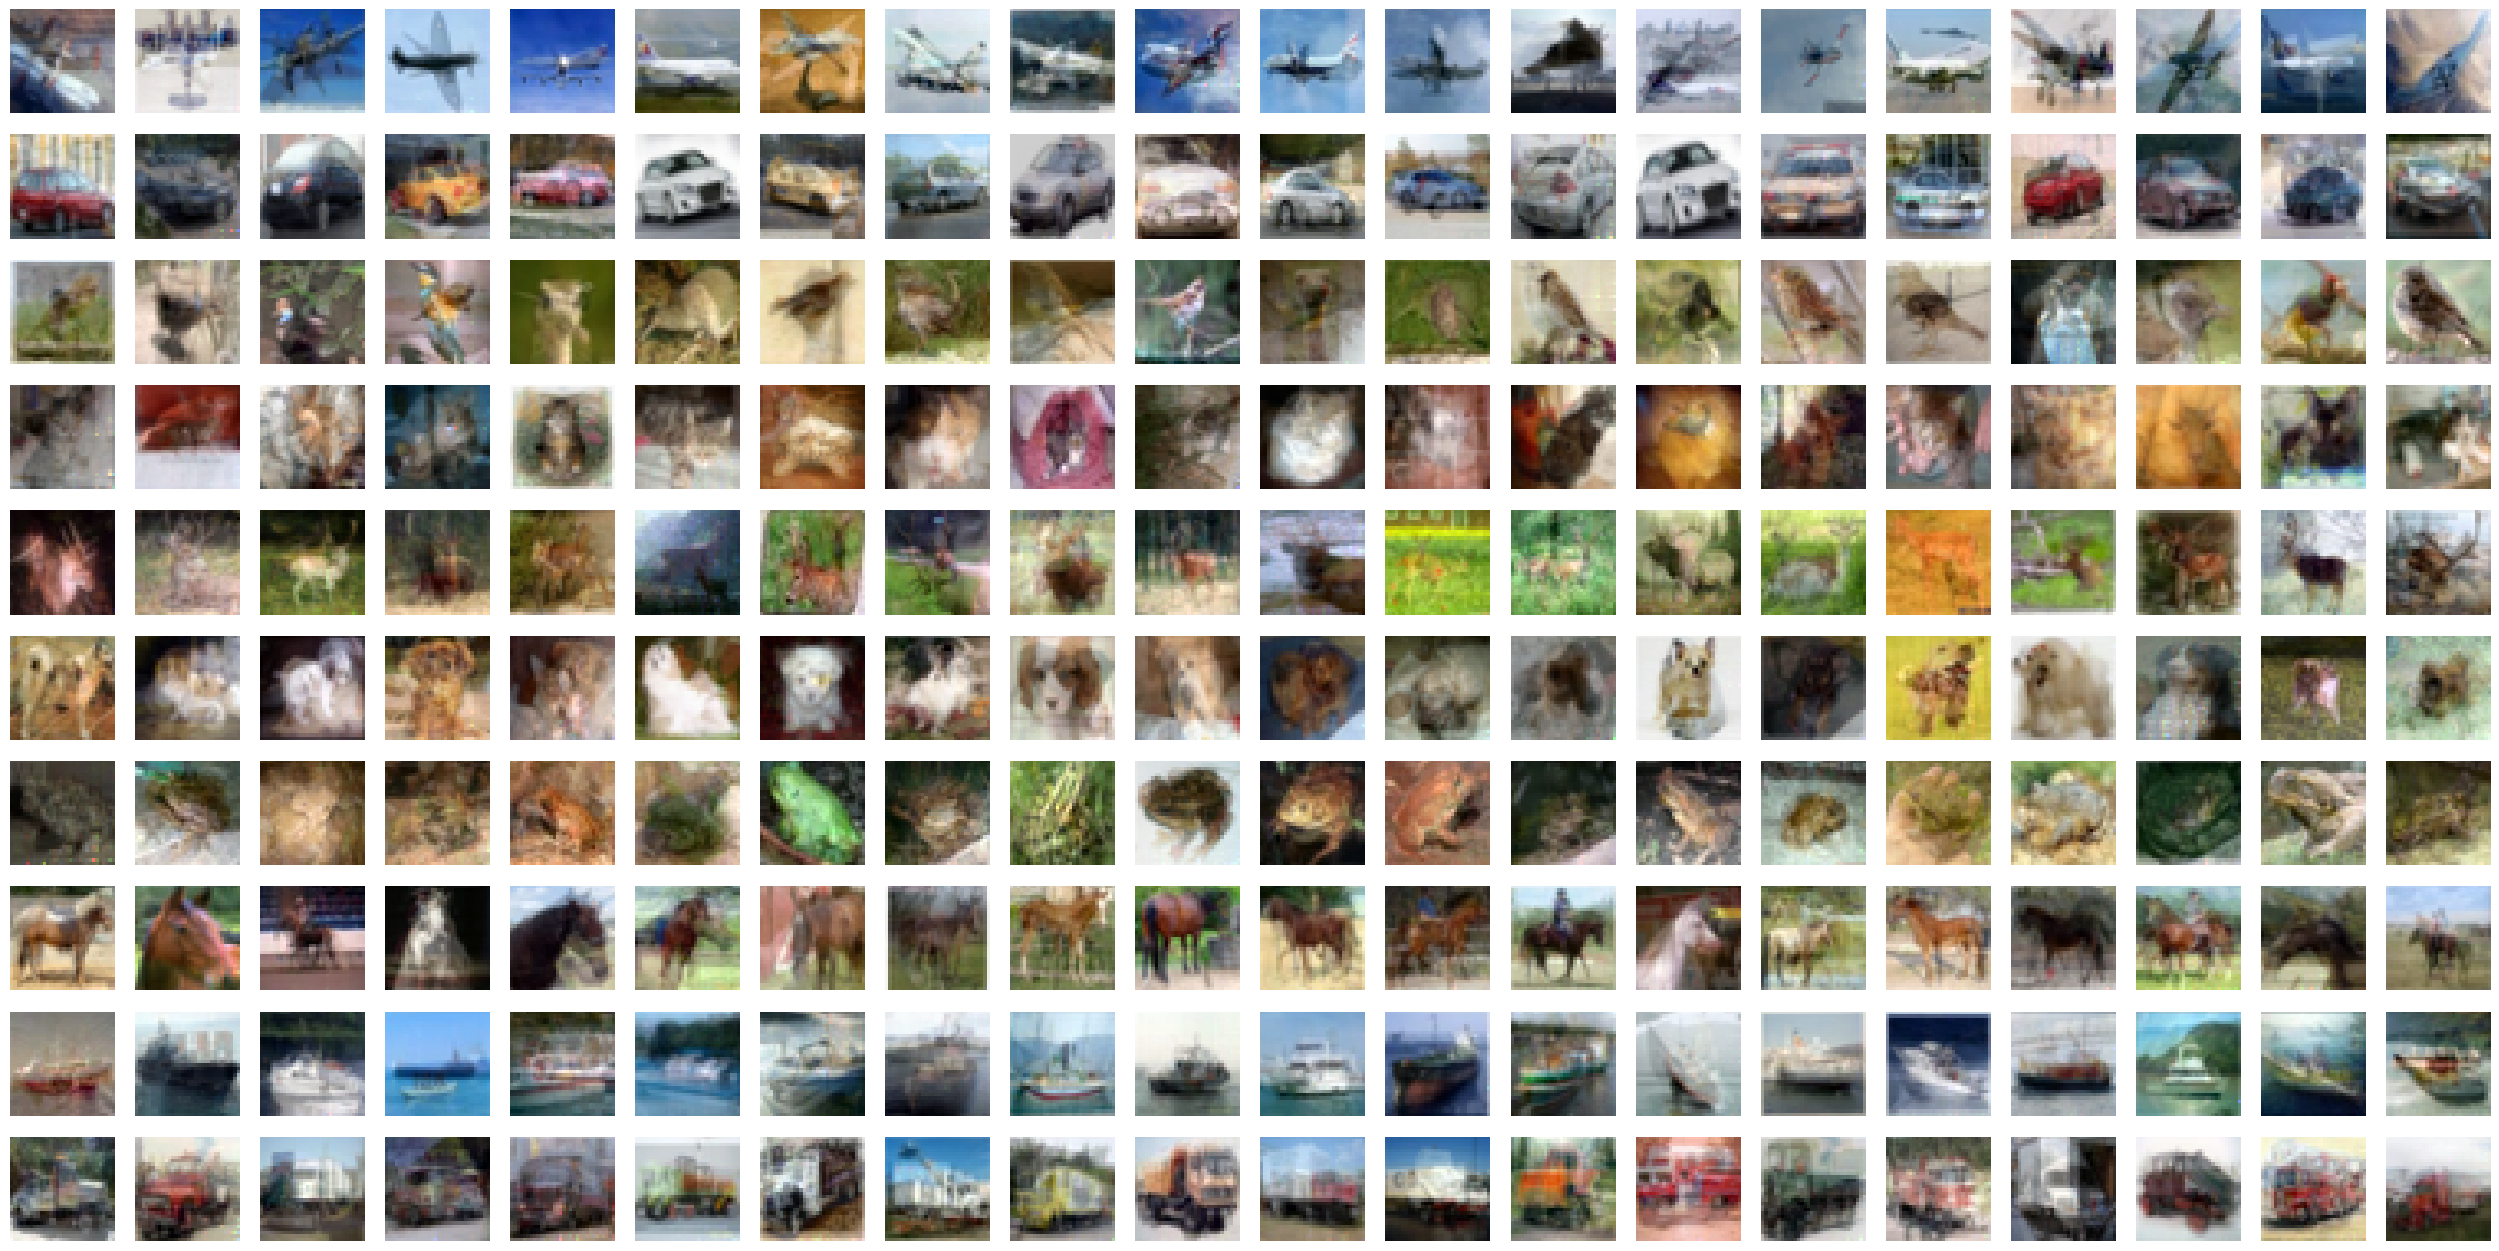

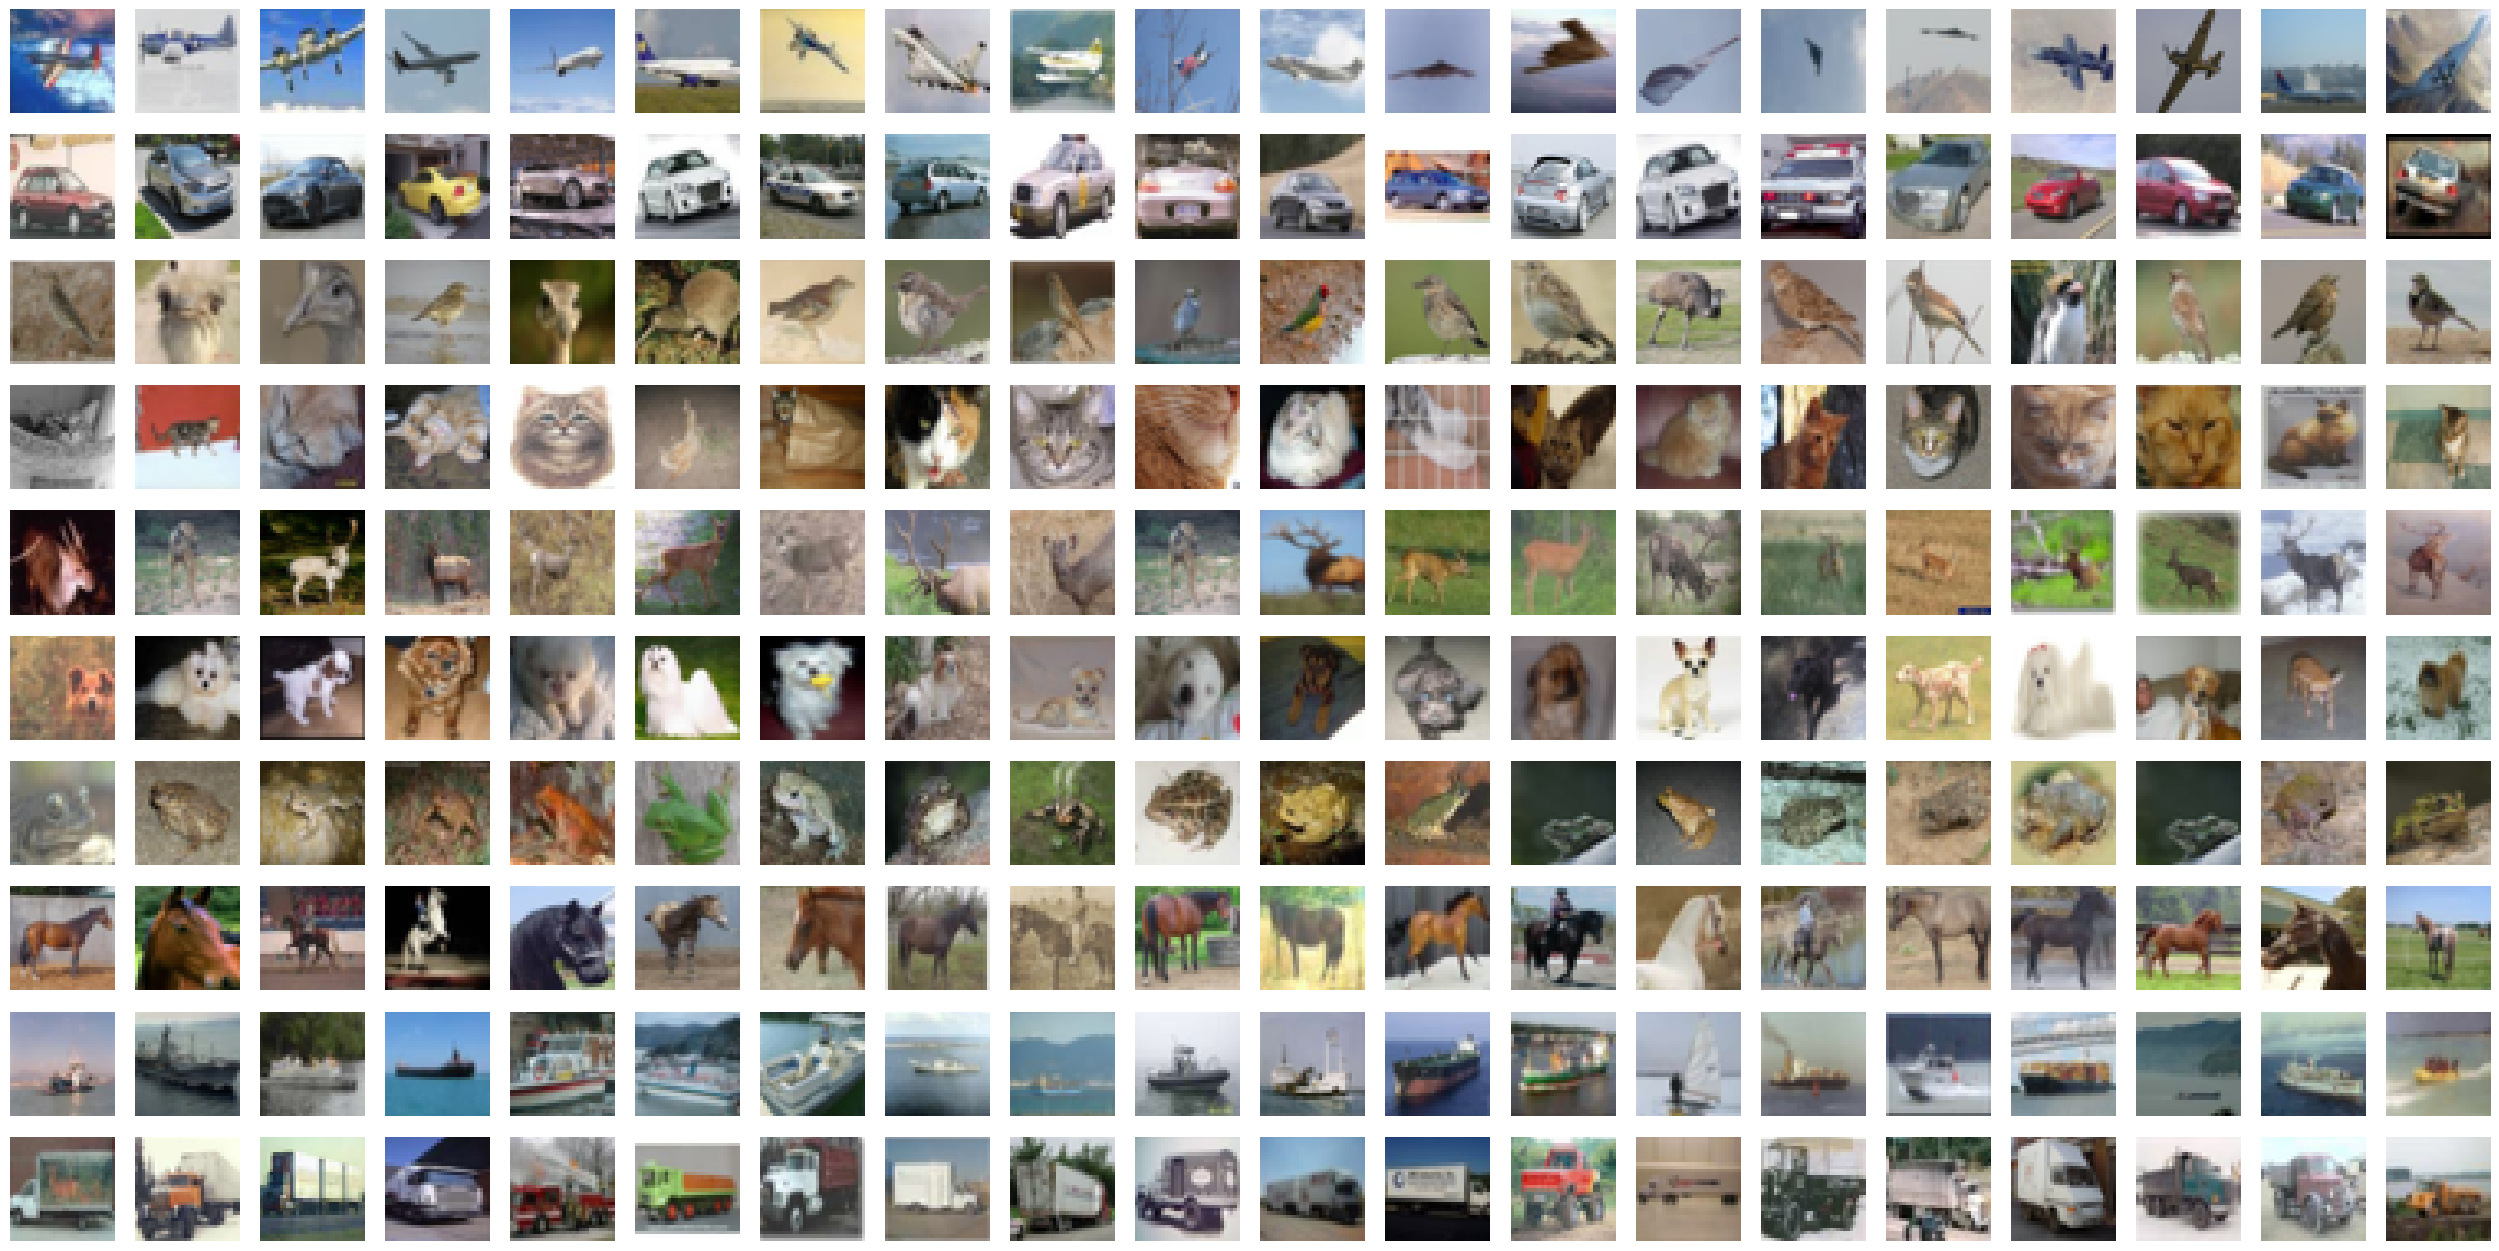

In [16]:
plt.figure(figsize=(32, 16))
for class_ in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, class_ * plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_BP_class[class_][i]).reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for class_ in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_X_BP_class[class_][i].reshape((32, 32, 3)) - p.reshape((32, 32, 3))) for p in P_class[class_]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, class_ * plot_num + i + 1)
        plt.imshow(P_class[class_][idx].reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

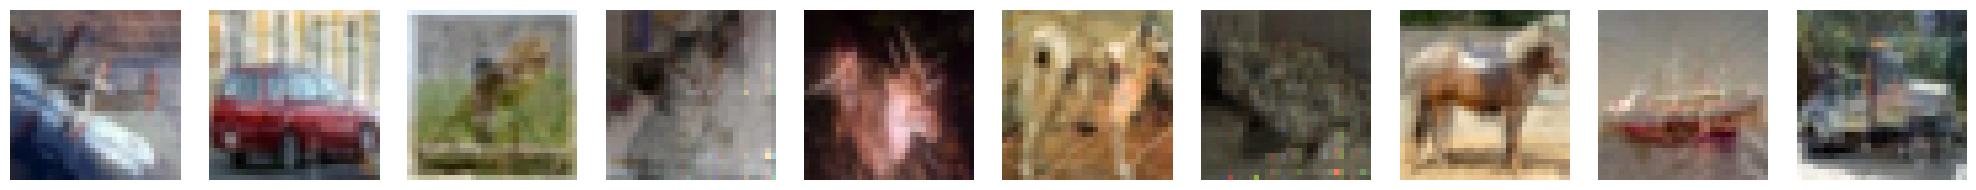

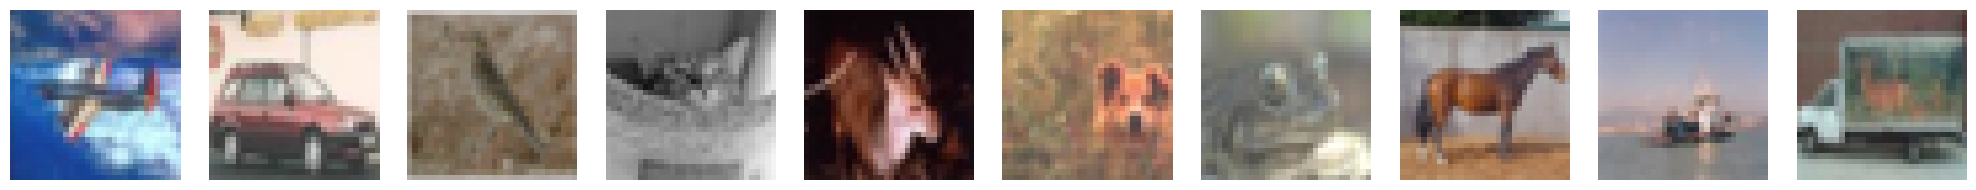

In [17]:
plt.figure(figsize=(20, 2))
for class_ in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, class_ * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_BP_class[class_][i]).reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/CIFAR/default/BP.pdf', format='pdf')

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for class_ in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_X_BP_class[class_][i].reshape((32, 32, 3)) - p.reshape((32, 32, 3))) for p in P_class[class_]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, class_ * paper_plot_num + i + 1)
        plt.imshow(P_class[class_][idx].reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/CIFAR/default/BP_compare.pdf', format='pdf')

plt.show()

## Data Augmentation with Autoencoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_size=D, hidden_size=256, z_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.fc2 = nn.Linear(hidden_size , hidden_size2)
        self.fc3 = nn.Linear(hidden_size, z_dim)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self, output_size=D, hidden_size=256, z_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(z_dim , hidden_size)
        # self.fc2 = nn.Linear(hidden_size , hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [8]:
train_loader_original = DataLoader(dataset=datasets.CIFAR10(root='./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])), batch_size=64, shuffle=True)

enc = Encoder().to(device)
dec = Decoder().to(device)
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

Files already downloaded and verified


In [20]:
train_loss = []
num_epochs = 500

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = 0
    for (imgs , _) in train_loader_original:
        imgs = imgs.to(device)
        imgs = imgs.permute(0 , 2 , 3 , 1)
        imgs = imgs.flatten(1)
        latents = enc(imgs)
        output = dec(latents)
        loss = loss_fn(output , imgs)
        train_epoch_loss += loss.cpu().detach().numpy()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
    train_loss.append(train_epoch_loss)
plt.plot(train_loss)

 31%|███       | 153/500 [41:40<1:29:42, 15.51s/it]

In [21]:
representation = None
AE_imgs = None
all_labels = []

with torch.no_grad():
    for (imgs , labels) in train_loader_original:
        imgs = imgs.to(device)
        imgs = imgs.permute(0 , 2 , 3 , 1)
        imgs = imgs.flatten(1)
        all_labels.extend(list(labels.numpy()))
        latents = enc(imgs)
        if representation is None:
            representation = latents.cpu()
        else:
            representation = torch.vstack([representation , latents.cpu()])

        if AE_imgs is None:
            AE_imgs = imgs.detach().cpu().numpy()
        else:
            AE_imgs = np.vstack([AE_imgs , imgs.detach().cpu().numpy()])

AE_class = []
for class_ in range(10):
    AE_class.append(AE_imgs[torch.tensor(all_labels) == class_])

all_labels = np.array(all_labels)
representation = representation.numpy()

In [22]:
sampled_X_AE_class = []

for class_ in range(10):
    sampled_X_AE_list = []

    rep = representation[np.argwhere(all_labels == class_)].squeeze()
    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_AE).fit(rep)

    # Sample new data from the KDE
    sampled_rep = kde.sample(n_samples=new_sample_size_per_digit)
    for i in range(new_sample_size_per_digit):
        pred = dec(torch.Tensor(sampled_rep[i])[None , ...].to(device)).cpu().detach().numpy()
        sampled_X_AE_list.append(pred)

    sampled_X_AE_class.append(sampled_X_AE_list)

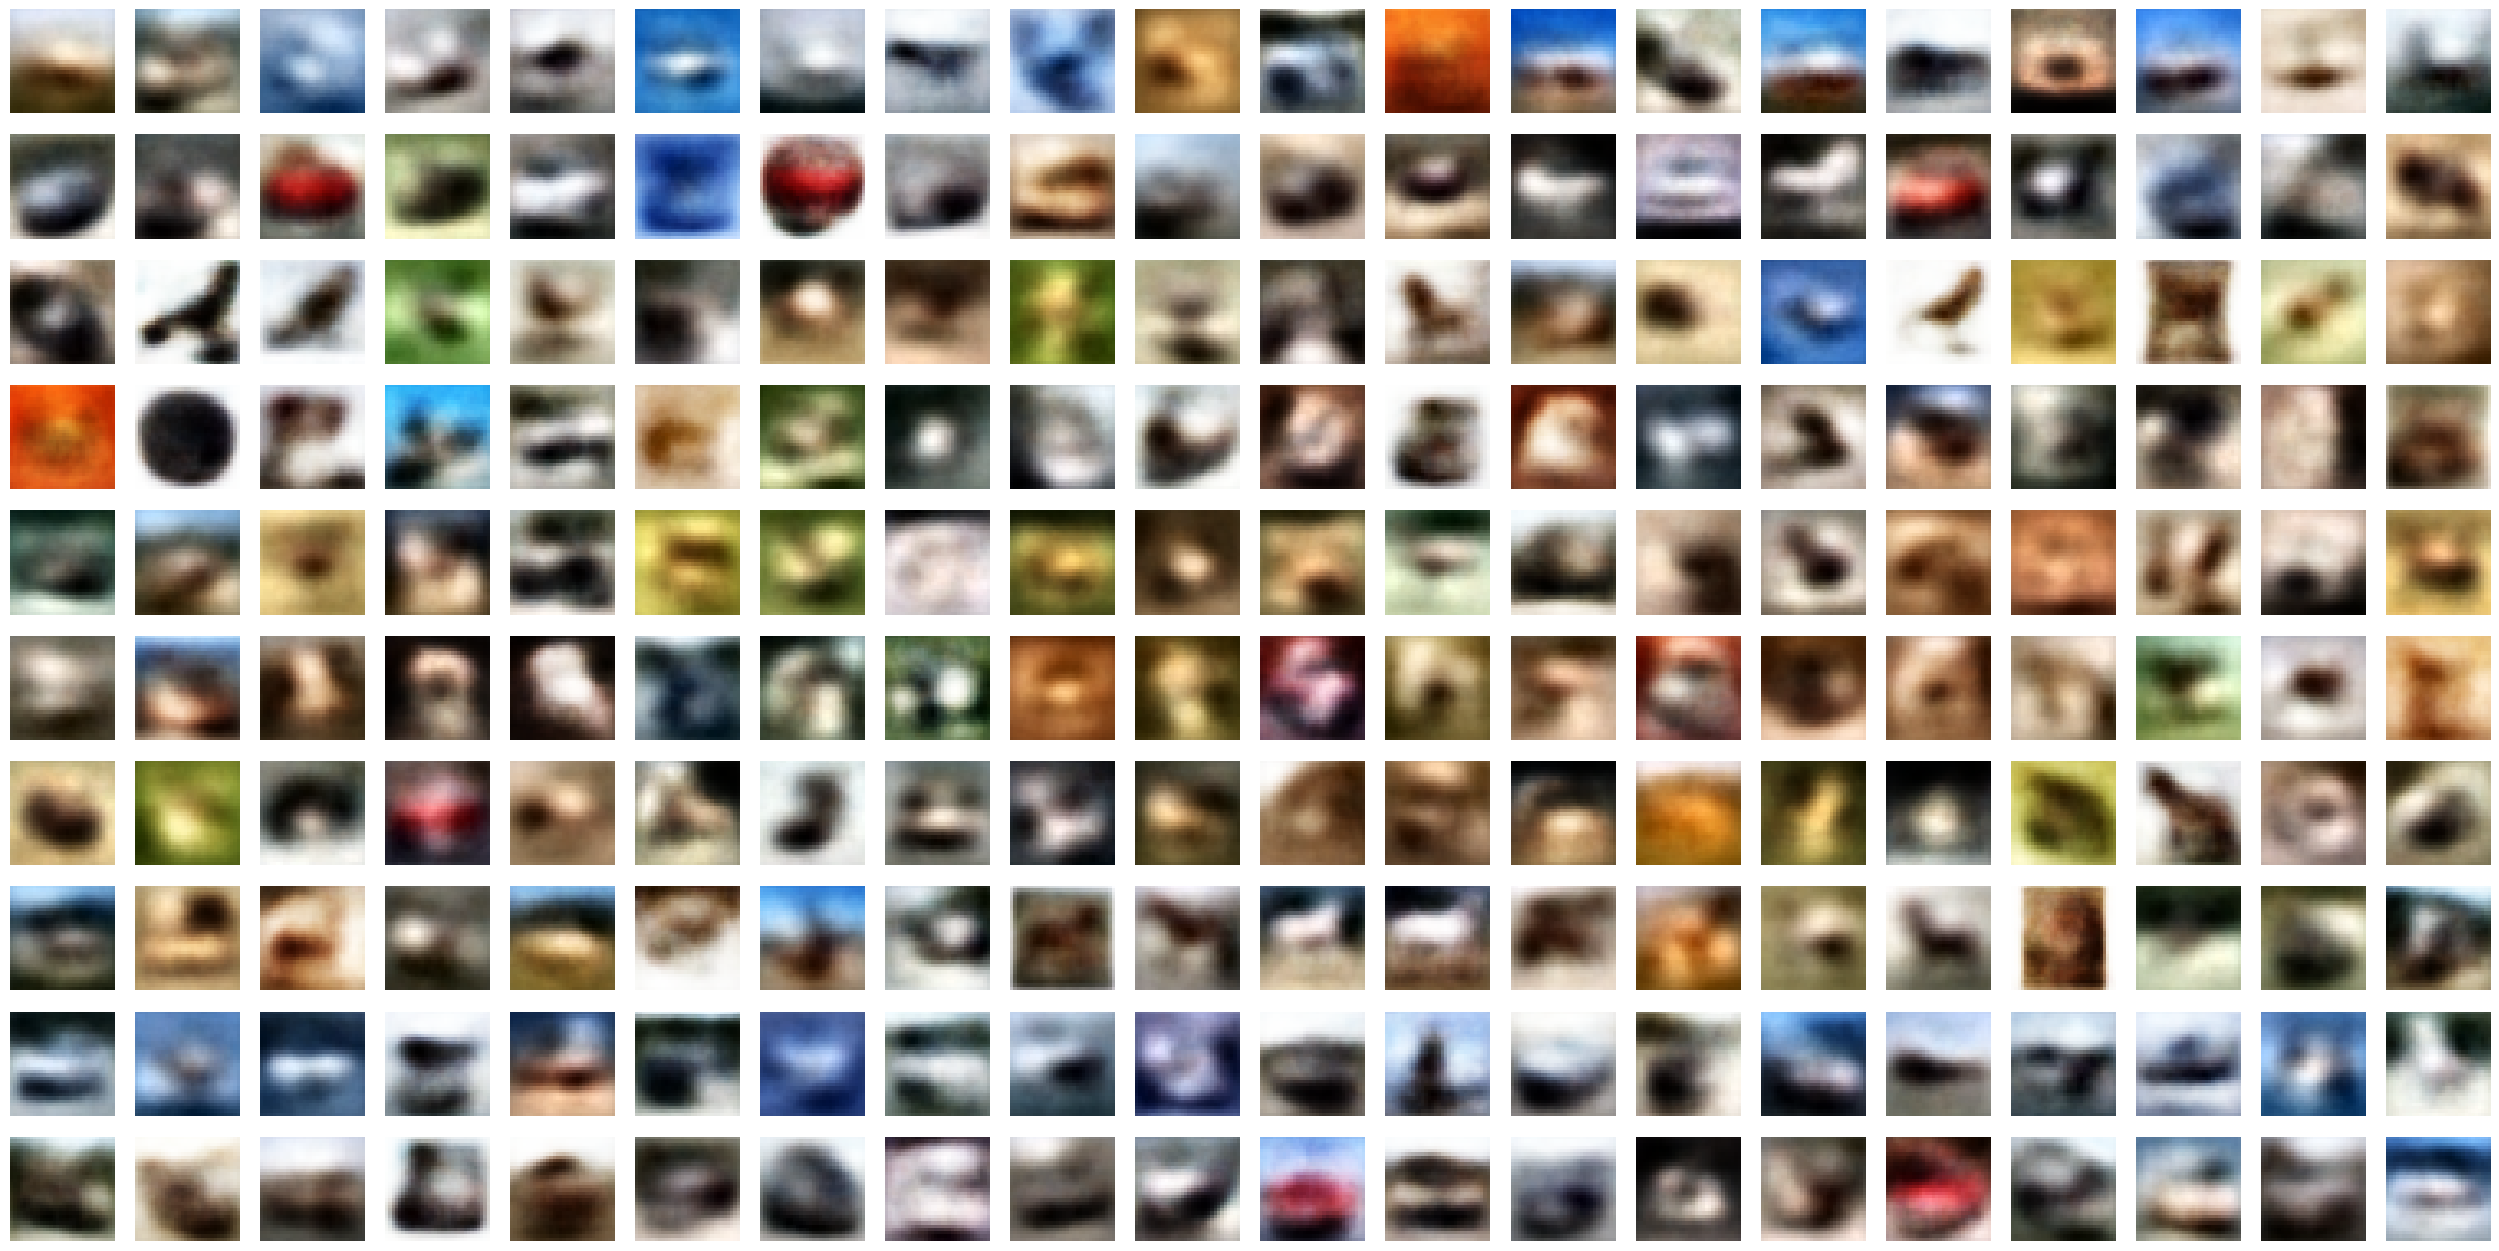

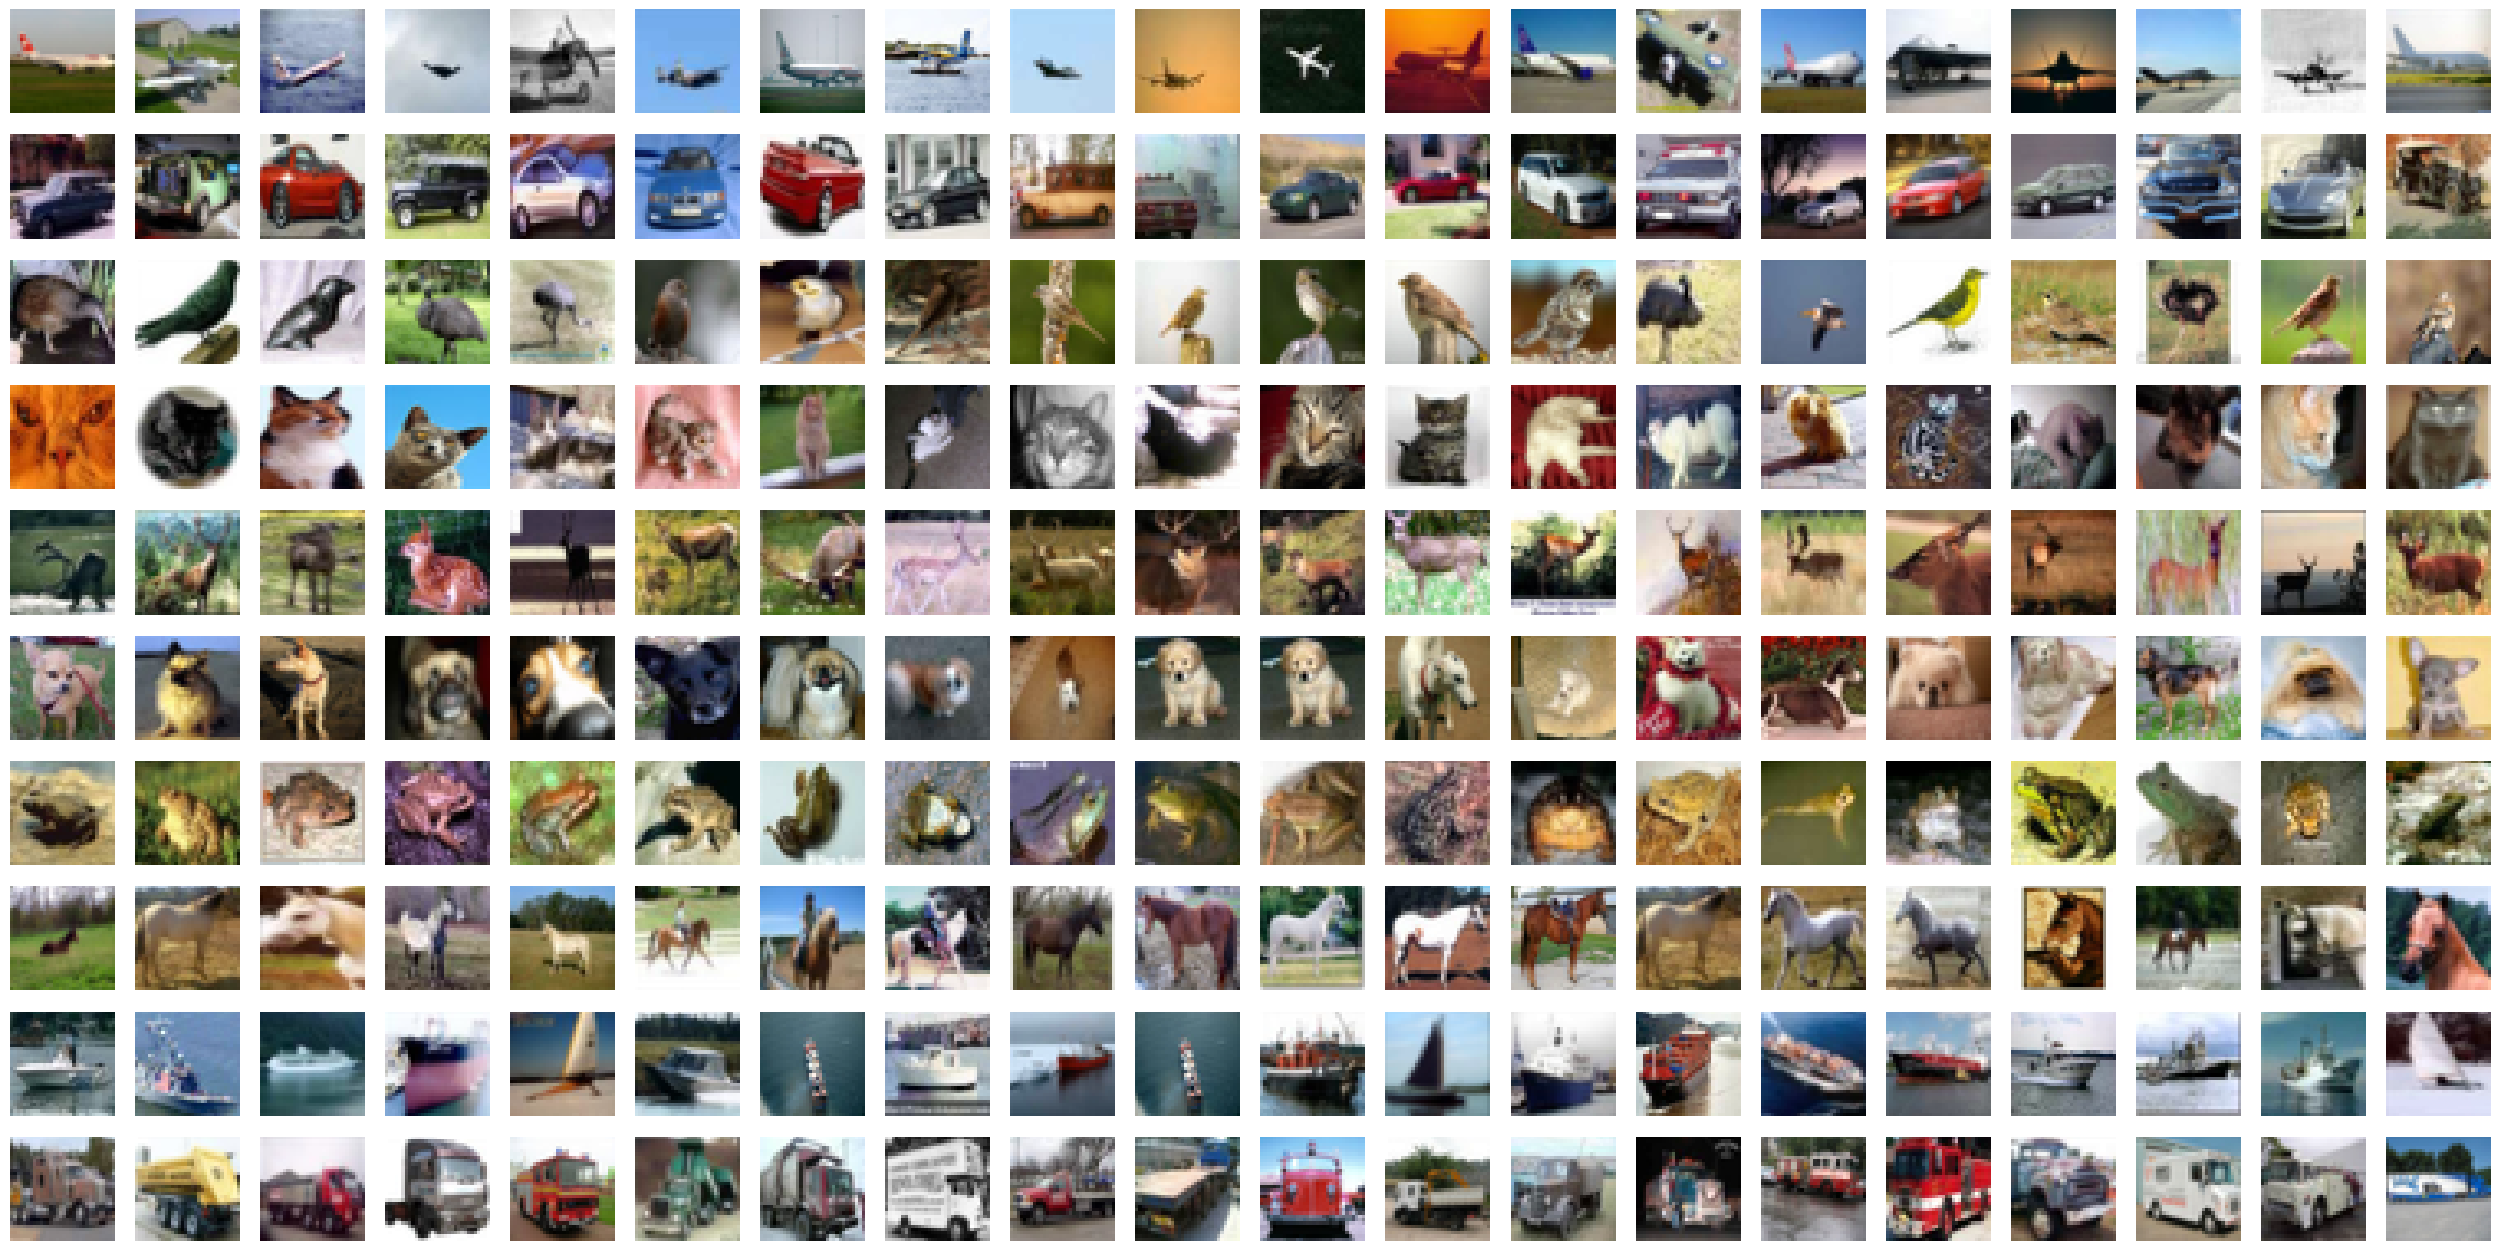

In [23]:
plt.figure(figsize=(32, 16))
for class_ in range(10):
    for i in range(plot_num):
        plt.subplot(10, plot_num, class_ * plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_AE_class[class_][i]).reshape(32, 32, 3), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(32, 16))
for class_ in range(10):
    for i in range(plot_num):
        norm = [np.linalg.norm(sampled_X_AE_class[class_][i].reshape((32, 32, 3)) - p.reshape((32, 32, 3))) for p in AE_class[class_]]
        idx = np.argmin(norm)
        plt.subplot(10, plot_num, class_ * plot_num + i + 1)
        plt.imshow(renormalize_image(AE_class[class_][idx]).reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.show()

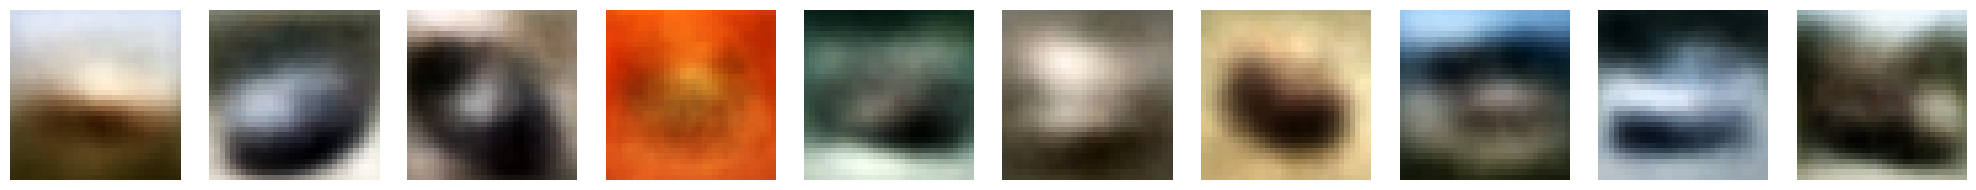

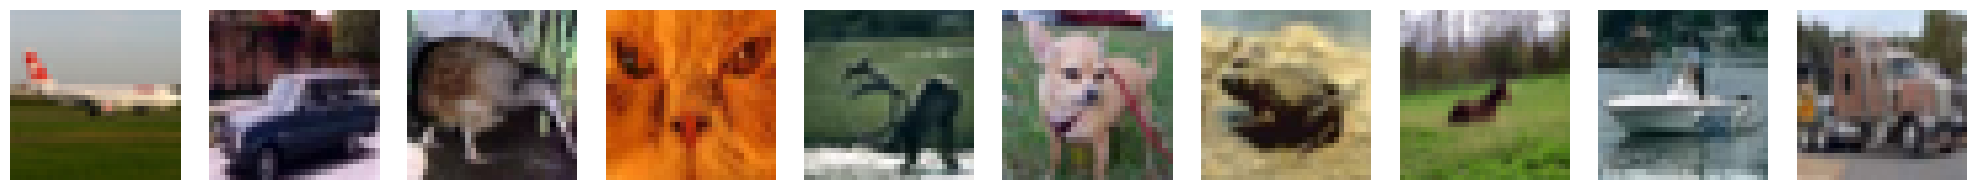

In [24]:
plt.figure(figsize=(20, 2))
for class_ in range(10):
    for i in range(paper_plot_num):
        plt.subplot(paper_plot_num, 10, class_ * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(sampled_X_AE_class[class_][i]).reshape(32, 32, 3), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/CIFAR/else/AE.pdf', format='pdf')

plt.show()

# Find the nearest distance between every new sample among the training set in terms of norm.
plt.figure(figsize=(20, 2))
for class_ in range(10):
    for i in range(paper_plot_num):
        norm = [np.linalg.norm(sampled_X_AE_class[class_][i].reshape((32, 32, 3)) - p.reshape((32, 32, 3))) for p in AE_class[class_]]
        idx = np.argmin(norm)
        plt.subplot(paper_plot_num, 10, class_ * paper_plot_num + i + 1)
        plt.imshow(renormalize_image(AE_class[class_][idx]).reshape((32, 32, 3)), cmap='gray', vmin=0, vmax=255) # [0, 255]
        plt.axis('off')  # Hide axes

plt.tight_layout()

plt.savefig('../Figures/CIFAR/else/AE_compare.pdf', format='pdf')

plt.show()

## Classification Performance

### Dataset Preparation

In [ ]:
# Helper function to create a DataLoader for augmented datasets
def prepare_augmented_dataset(cifar_dataset, augmented_data, augmented_labels, transform, batch_size):
    # Create dataset from augmented data
    augmented_dataset = NumpyDataset(data=augmented_data, labels=augmented_labels, transform=transform)

    # Combine with the original CIFAR-10 dataset
    combined_dataset = ConcatDataset([cifar_dataset, augmented_dataset])

    # Create a DataLoader for the combined dataset
    return DataLoader(dataset=combined_dataset, batch_size=batch_size, shuffle=True)

# Main function to prepare datasets and loaders
def create_datasets_and_loaders(batch_size=64):
    # Transformations
    transform_standard = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ])
    transform_none = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ])
    transform_none_augmented = transforms.Compose([
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ])

    # CIFAR-10 Datasets
    cifar_train_standard = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_standard)
    cifar_train_none = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_none)

    augmented_data_PNL = []
    labels_PNL = []
    augmented_data_AE = []
    labels_AE = []

    for class_ in range(10):
        for img_PNL in sampled_X_BP_class[class_]:
            augmented_data_PNL.append(renormalize_image(img_PNL).reshape((32, 32, 3)))
            labels_PNL.append(class_)

        for img_AE in sampled_X_AE_class[class_]:
            augmented_data_AE.append(renormalize_image(img_AE).reshape((32, 32, 3)))
            labels_AE.append(class_)

    augmented_data_PNL = np.array(augmented_data_PNL)
    labels_PNL = np.array(labels_PNL)
    augmented_data_AE = np.array(augmented_data_AE)
    labels_AE = np.array(labels_AE)

    # Combine CIFAR-10 with augmented data
    train_loader_PNL = prepare_augmented_dataset(cifar_train_none, augmented_data_PNL, labels_PNL, transform_none_augmented, batch_size)
    train_loader_AE = prepare_augmented_dataset(cifar_train_none, augmented_data_AE, labels_AE, transform_none_augmented, batch_size)

    # DataLoader for CIFAR-10 only
    train_loader_standard = DataLoader(cifar_train_standard, batch_size=batch_size, shuffle=True)
    train_loader_none = DataLoader(cifar_train_none, batch_size=batch_size, shuffle=True)

    return {
        "standard": train_loader_standard,
        "none": train_loader_none,
        "PNL_augmented": train_loader_PNL,
        "AE_augmented": train_loader_AE,
    }

loaders = create_datasets_and_loaders(batch_size=64)

# Check each DataLoader
for name, loader in loaders.items():
    print(f"{name} loader:")
    for images, labels in loader:
        print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
        break

train_loader_standard = loaders["standard"]
train_loader_none = loaders["none"]
train_loader_PNL = loaders["PNL_augmented"]
train_loader_AE = loaders["AE_augmented"]

Files already downloaded and verified
Files already downloaded and verified
standard loader:
Images shape: torch.Size([64, 3, 32, 32]), Labels shape: torch.Size([64])
none loader:
Images shape: torch.Size([64, 3, 32, 32]), Labels shape: torch.Size([64])
LD_augmented loader:
Images shape: torch.Size([64, 3, 32, 32]), Labels shape: torch.Size([64])
AE_augmented loader:
Images shape: torch.Size([64, 3, 32, 32]), Labels shape: torch.Size([64])


### ResNet18 Model

In [26]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=False)  # Load ResNet18
        # Adjust first convolution for CIFAR-10
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.maxpool = nn.Identity()  # Remove max-pooling layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Adjust for CIFAR-10 classes

    def forward(self, x):
        return self.resnet(x)

def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Adjust learning rate
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

def test_model(model, test_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def bootstrapping(train_loader, test_dataset, num_epochs=100, learning_rate=1e-1, n_bootstrap=20, device='cuda'):
    """
    Train the ResNet model on the training dataset, and evaluate it using bootstrapping on the test dataset.

    Args:
        train_loader: DataLoader for training data.
        test_dataset: Dataset object for the test data.
        num_epochs: Number of epochs for training.
        learning_rate: Learning rate for the optimizer.
        device: Device to run the training on ('cuda' or 'cpu').

    Returns:
        Prints the mean accuracy and 95% confidence interval after bootstrapping.
    """
    # Initialize the model, loss, optimizer, and scheduler
    model = ResNetModel(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Decay LR every 30 epochs

    # Train the model
    train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=num_epochs, device=device)

    # Perform bootstrapping
    accuracies = []

    num_test_samples = len(test_dataset) // 2
    for i in range(n_bootstrap):
        indices = torch.randint(len(test_dataset), size=(num_test_samples,))  # Sample 500 random indices
        bootstrap_subset = Subset(test_dataset, indices)
        bootstrap_loader = DataLoader(dataset=bootstrap_subset, batch_size=num_test_samples, shuffle=False)

        accuracy = test_model(model, bootstrap_loader, device=device)
        accuracies.append(accuracy)

    # Compute statistics
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print(f"Mean accuracy: {mean_accuracy:.2f}%")
    print(f"Standard deviation: {std_accuracy:.2f}")

### Dataset Performance

In [28]:
bootstrapping(train_loader_none, test_dataset, num_epochs=50, learning_rate=0.1, device=device)

Epoch [1/50], Loss: 2.0077
Epoch [2/50], Loss: 1.3950
Epoch [3/50], Loss: 1.0164
Epoch [4/50], Loss: 0.7869
Epoch [5/50], Loss: 0.6729
Epoch [6/50], Loss: 0.5936
Epoch [7/50], Loss: 0.5536
Epoch [8/50], Loss: 0.5083
Epoch [9/50], Loss: 0.4769
Epoch [10/50], Loss: 0.4619
Epoch [11/50], Loss: 0.4486
Epoch [12/50], Loss: 0.4335
Epoch [13/50], Loss: 0.4226
Epoch [14/50], Loss: 0.4095
Epoch [15/50], Loss: 0.4089
Epoch [16/50], Loss: 0.3904
Epoch [17/50], Loss: 0.3924
Epoch [18/50], Loss: 0.3814
Epoch [19/50], Loss: 0.3804
Epoch [20/50], Loss: 0.3751
Epoch [21/50], Loss: 0.3745
Epoch [22/50], Loss: 0.3736
Epoch [23/50], Loss: 0.3663
Epoch [24/50], Loss: 0.3643
Epoch [25/50], Loss: 0.3665
Epoch [26/50], Loss: 0.3620
Epoch [27/50], Loss: 0.3588
Epoch [28/50], Loss: 0.3544
Epoch [29/50], Loss: 0.3552
Epoch [30/50], Loss: 0.3541
Epoch [31/50], Loss: 0.1078
Epoch [32/50], Loss: 0.0347
Epoch [33/50], Loss: 0.0152
Epoch [34/50], Loss: 0.0090
Epoch [35/50], Loss: 0.0060
Epoch [36/50], Loss: 0.0051
E

In [ ]:
bootstrapping(train_loader_standard, test_dataset, num_epochs=50, learning_rate=0.1, device=device)

In [29]:
bootstrapping(train_loader_PNL, test_dataset, num_epochs=50, learning_rate=0.01, device=device)

Epoch [1/50], Loss: 1.3186


Epoch [2/50], Loss: 0.7596
Epoch [3/50], Loss: 0.5248
Epoch [4/50], Loss: 0.3751
Epoch [5/50], Loss: 0.2625
Epoch [6/50], Loss: 0.1852
Epoch [7/50], Loss: 0.1242
Epoch [8/50], Loss: 0.1092
Epoch [9/50], Loss: 0.0854
Epoch [10/50], Loss: 0.0771
Epoch [11/50], Loss: 0.0615
Epoch [12/50], Loss: 0.0482
Epoch [13/50], Loss: 0.0460
Epoch [14/50], Loss: 0.0486
Epoch [15/50], Loss: 0.0471
Epoch [16/50], Loss: 0.0532
Epoch [17/50], Loss: 0.0495
Epoch [18/50], Loss: 0.0430
Epoch [19/50], Loss: 0.0393
Epoch [20/50], Loss: 0.0437
Epoch [21/50], Loss: 0.0514
Epoch [22/50], Loss: 0.0446
Epoch [23/50], Loss: 0.0365
Epoch [24/50], Loss: 0.0398
Epoch [25/50], Loss: 0.0489
Epoch [26/50], Loss: 0.0335
Epoch [27/50], Loss: 0.0396
Epoch [28/50], Loss: 0.0497
Epoch [29/50], Loss: 0.0563
Epoch [30/50], Loss: 0.0386
Epoch [31/50], Loss: 0.0126
Epoch [32/50], Loss: 0.0043
Epoch [33/50], Loss: 0.0031
Epoch [34/50], Loss: 0.0026
Epoch [35/50], Loss: 0.0023
Epoch [36/50], Loss: 0.0022
Epoch [37/50], Loss: 0.0021


In [30]:
bootstrapping(train_loader_AE, test_dataset, num_epochs=50, learning_rate=0.01, device=device)

Epoch [1/50], Loss: 1.4219
Epoch [2/50], Loss: 0.9279
Epoch [3/50], Loss: 0.6968
Epoch [4/50], Loss: 0.5335
Epoch [5/50], Loss: 0.4076
Epoch [6/50], Loss: 0.3222
Epoch [7/50], Loss: 0.2528
Epoch [8/50], Loss: 0.2135
Epoch [9/50], Loss: 0.1712
Epoch [10/50], Loss: 0.1524
Epoch [11/50], Loss: 0.1244
Epoch [12/50], Loss: 0.1052
Epoch [13/50], Loss: 0.1010
Epoch [14/50], Loss: 0.1030
Epoch [15/50], Loss: 0.0934
Epoch [16/50], Loss: 0.0765
Epoch [17/50], Loss: 0.0622
Epoch [18/50], Loss: 0.0738
Epoch [19/50], Loss: 0.0695
Epoch [20/50], Loss: 0.0620
Epoch [21/50], Loss: 0.0646
Epoch [22/50], Loss: 0.0605
Epoch [23/50], Loss: 0.0511
Epoch [24/50], Loss: 0.0583
Epoch [25/50], Loss: 0.0716
Epoch [26/50], Loss: 0.0608
Epoch [27/50], Loss: 0.0607
Epoch [28/50], Loss: 0.0523
Epoch [29/50], Loss: 0.0549
Epoch [30/50], Loss: 0.0607
Epoch [31/50], Loss: 0.0232
Epoch [32/50], Loss: 0.0062
Epoch [33/50], Loss: 0.0045
Epoch [34/50], Loss: 0.0037
Epoch [35/50], Loss: 0.0030
Epoch [36/50], Loss: 0.0028
E